# House Prices 데이터 전처리 실습 (정답 포함)

이 노트북은 Kaggle House Prices 데이터셋(`House Prices - Advanced Regression Techniques.csv`)을 이용해
결측값 처리, 깊은 복사/얕은 복사, 이상치 탐색 등을 단계적으로 연습하기 위한 실습 문제 모음입니다.

## 학습 목표
1. 결측값 탐색과 처리
2. 수치형 vs 범주형 컬럼 별로 다른 방식의 결측값 대체
3. 얕은 복사(shallow copy)와 깊은 복사(deep copy)의 차이
4. 이상치(outlier) 탐지 및 제거 (IQR 방식)
5. 전처리 파이프라인 구성 및 전/후 비교

아래 셀을 먼저 실행해서 데이터를 불러오세요.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8')
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 데이터 불러오기
df = pd.read_csv("./data/05_House Prices - Advanced Regression Techniques.csv")

df.head()


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## 문제 1️⃣: 데이터 구조 파악하기
- 데이터의 행/열 수(shape)를 확인하세요.
- 주요 수치형 변수들의 기본 통계(describe())를 확인하세요.
- info()를 통해 각 컬럼의 결측 여부와 타입을 확인하세요.

In [3]:
df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [2]:
print('데이터 크기:', df.shape)

display(df.describe(include=[np.number]))

df.info()


데이터 크기: (1460, 81)


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

## 문제 2️⃣: 결측값 개수 확인하기
- 각 컬럼별 결측값(null) 개수를 계산하고, 많은 순으로 정렬하여 상위 10개를 출력하세요.
- 어떤 컬럼들이 결측이 심한지 파악하세요.

In [3]:
null_counts = df.isnull().sum().sort_values(ascending=False)
null_counts.head(10)


PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageQual        81
GarageFinish      81
GarageType        81
dtype: int64

## 문제 3️⃣: 결측 비율(%) 확인하기
- 각 컬럼별 결측 비율(결측 개수 / 전체 행 수 * 100)을 구한 뒤,
  비율이 높은 순서대로 정렬하여 상위 10개를 시각화(barh)하세요.
- 그래프 제목: `결측 비율 상위 컬럼`

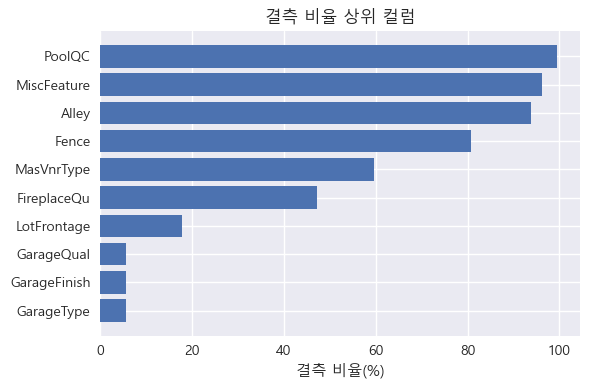

PoolQC          99.520548
MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
MasVnrType      59.726027
FireplaceQu     47.260274
LotFrontage     17.739726
GarageQual       5.547945
GarageFinish     5.547945
GarageType       5.547945
dtype: float64

In [4]:
missing_ratio = (df.isnull().sum() / len(df) * 100).sort_values(ascending=False)

top10 = missing_ratio.head(10)

plt.figure(figsize=(6,4))
plt.barh(top10.index, top10.values)
plt.gca().invert_yaxis()  # 높은 비율이 위로 오도록
plt.title('결측 비율 상위 컬럼')
plt.xlabel('결측 비율(%)')
plt.tight_layout()
plt.show()

top10


## 문제 4️⃣: 수치형 결측값 처리 (LotFrontage 예시)
- `LotFrontage`는 땅이 도로와 맞닿은 길이입니다. 이 컬럼은 결측이 존재합니다.
- 1) 원본에서 `LotFrontage`의 평균(mean)과 중앙값(median)을 계산하세요.
- 2) `LotFrontage`의 결측을 **중앙값**으로 채운 새 DataFrame `df_numfilled`를 만드세요.
- 3) 채우기 전/후의 결측 개수를 비교하세요.

In [5]:
median_val = df['LotFrontage'].median()
mean_val = df['LotFrontage'].mean()
print('LotFrontage mean:', mean_val)
print('LotFrontage median:', median_val)

df_numfilled = df.copy()
df_numfilled['LotFrontage'] = df_numfilled['LotFrontage'].fillna(median_val)

before_na = df['LotFrontage'].isnull().sum()
after_na  = df_numfilled['LotFrontage'].isnull().sum()
print('결측 (before, after):', before_na, after_na)


LotFrontage mean: 70.04995836802665
LotFrontage median: 69.0
결측 (before, after): 259 0


## 문제 5️⃣: 범주형 결측값 처리 (GarageType 예시)
- `GarageType`은 차고의 형태(Attached, Detached 등)를 나타냅니다. 결측은 '차고 없음'일 가능성이 큽니다.
- 1) `GarageType`의 현재 고유값(value_counts(dropna=False))을 확인하세요.
- 2) 결측값을 문자열 `'None'`으로 채운 새 DataFrame `df_catfilled`를 만드세요.
- 3) 채우기 전/후 결측 개수를 비교하세요.

In [6]:
df_catfilled = df.copy()

print('GarageType 고유값 (채우기 전):')
print(df_catfilled['GarageType'].value_counts(dropna=False))

df_catfilled['GarageType'] = df_catfilled['GarageType'].fillna('None')

before_na = df['GarageType'].isnull().sum()
after_na  = df_catfilled['GarageType'].isnull().sum()
print('결측 (before, after):', before_na, after_na)

print('\nGarageType 고유값 (채우기 후):')
print(df_catfilled['GarageType'].value_counts(dropna=False))


GarageType 고유값 (채우기 전):
GarageType
Attchd     870
Detchd     387
BuiltIn     88
NaN         81
Basment     19
CarPort      9
2Types       6
Name: count, dtype: int64
결측 (before, after): 81 0

GarageType 고유값 (채우기 후):
GarageType
Attchd     870
Detchd     387
BuiltIn     88
None        81
Basment     19
CarPort      9
2Types       6
Name: count, dtype: int64


## 문제 6️⃣: 전체 결측 처리 버전 만들기
- 다음 규칙으로 새로운 DataFrame `df_filled`를 만드세요.
  - 수치형 컬럼은 중앙값(median)으로 채운다.
  - 범주형 컬럼(object 타입)은 `'Unknown'`으로 채운다.
- 그런 다음 df_filled에 남아있는 결측값 개수를 모두 합산하여 출력하세요.

In [7]:
df_filled = df.copy()

for col in df_filled.columns:
    if df_filled[col].dtype != 'object':
        # 수치형: 중앙값으로 채우기
        df_filled[col] = df_filled[col].fillna(df_filled[col].median())
    else:
        # 범주형: 'Unknown'으로 채우기
        df_filled[col] = df_filled[col].fillna('Unknown')

print('남아있는 결측 총합:', df_filled.isnull().sum().sum())


남아있는 결측 총합: 0


## 문제 7️⃣: 얕은 복사 vs 깊은 복사
- 얕은 복사(shallow copy)와 깊은 복사(deep copy)의 차이를 관찰해봅니다.
- 1) `df_shallow = df` 로 얕은 복사를 만드세요.
- 2) `df_deep = df.copy()` 로 깊은 복사를 만드세요.
- 3) 얕은 복사 쪽의 특정 컬럼(예: `LotArea`) 값을 변경했을 때 원본 df도 함께 바뀌는지 확인하세요.
- 4) 깊은 복사쪽은 독립적인지 확인하세요.

In [8]:
df_shallow = df            # 얕은 복사 (참조만 복사)
df_deep = df.copy()        # 깊은 복사 (새 객체)

print('원본 LotArea head:')
print(df['LotArea'].head())

# 얕은 복사 수정
df_shallow.loc[df_shallow.index[0], 'LotArea'] = -999

print('\n얕은 복사 수정 후 df LotArea head:')
print(df['LotArea'].head())

print('\n깊은 복사 df_deep LotArea head:')
print(df_deep['LotArea'].head())

# 복구 (실습 중 원본 더럽히지 않도록)
df.loc[df.index[0], 'LotArea'] = df_deep.loc[df_deep.index[0], 'LotArea']


원본 LotArea head:
0     8450
1     9600
2    11250
3     9550
4    14260
Name: LotArea, dtype: int64

얕은 복사 수정 후 df LotArea head:
0     -999
1     9600
2    11250
3     9550
4    14260
Name: LotArea, dtype: int64

깊은 복사 df_deep LotArea head:
0     8450
1     9600
2    11250
3     9550
4    14260
Name: LotArea, dtype: int64


## 문제 8️⃣: 이상치 탐색 (IQR 방식)
- `SalePrice`(집값)에서 이상치를 확인합니다.
- 1) 1사분위(Q1), 3사분위(Q3), IQR(Q3-Q1)을 구하세요.
- 2) IQR*1.5 바깥(아주 비싼 집/아주 싼 집)을 이상치로 간주하세요.
- 3) Boxplot으로 `SalePrice` 분포를 시각화하세요.
- 그래프 제목: `SalePrice Boxplot (이상치 확인)`

Q1: 129975.0 Q3: 214000.0 IQR: 84025.0
Lower bound: 3937.5 Upper bound: 340037.5
이상치 개수: 61


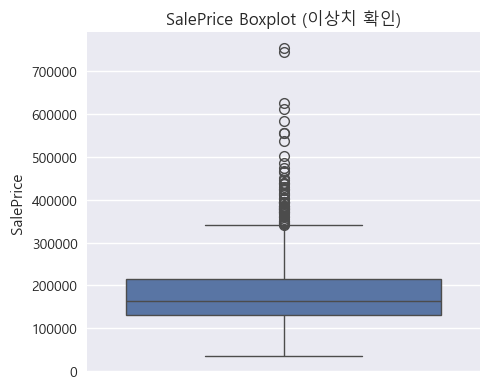

In [9]:
Q1 = df['SalePrice'].quantile(0.25)
Q3 = df['SalePrice'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print('Q1:', Q1, 'Q3:', Q3, 'IQR:', IQR)
print('Lower bound:', lower_bound, 'Upper bound:', upper_bound)

outliers = df[(df['SalePrice'] < lower_bound) | (df['SalePrice'] > upper_bound)]
print('이상치 개수:', len(outliers))

plt.figure(figsize=(5,4))
sns.boxplot(y='SalePrice', data=df)
plt.title('SalePrice Boxplot (이상치 확인)')
plt.tight_layout()
plt.show()


## 문제 9️⃣: 전처리된 DataFrame 생성하기
- 다음 단계로 `df_clean`을 만드세요.
  1) 수치형 컬럼 결측 → 중앙값으로 채우기
  2) 범주형 결측 → 'Unknown'으로 채우기
  3) `SalePrice`에서 IQR 기준 극단 이상치 행 제거
- 마지막으로 df_clean의 shape과 남은 결측값 총합을 출력하세요.

In [10]:
# 1,2 결측 처리
df_clean = df.copy()
for col in df_clean.columns:
    if df_clean[col].dtype != 'object':
        df_clean[col] = df_clean[col].fillna(df_clean[col].median())
    else:
        df_clean[col] = df_clean[col].fillna('Unknown')

# 3 이상치 제거 (SalePrice 기준)
Q1 = df_clean['SalePrice'].quantile(0.25)
Q3 = df_clean['SalePrice'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_clean = df_clean[(df_clean['SalePrice'] >= lower_bound) & (df_clean['SalePrice'] <= upper_bound)]

print('df_clean shape:', df_clean.shape)
print('남은 결측 총합:', df_clean.isnull().sum().sum())


df_clean shape: (1399, 81)
남은 결측 총합: 0


## 문제 🔟: 전처리 전 / 후 비교
- 원본 df와 전처리 후 df_clean에서
  `SalePrice`, `LotArea`, `GrLivArea` 같은 핵심 수치형 컬럼의
  평균(mean)과 표준편차(std)를 비교해보세요.
- 전처리(결측 대체 + 이상치 제거)가 데이터 분포에 어떤 영향을 주는지 해석해보세요.

In [11]:
cols_to_check = ['SalePrice', 'LotArea', 'GrLivArea']

summary_before = df[cols_to_check].describe().T[['mean','std','min','max']]
summary_before.columns = ['mean_before','std_before','min_before','max_before']

# df_clean이 전 셀에서 만들어졌다고 가정
summary_after = df_clean[cols_to_check].describe().T[['mean','std','min','max']]
summary_after.columns = ['mean_after','std_after','min_after','max_after']

comparison = pd.concat([summary_before, summary_after], axis=1)
comparison


,mean_before,std_before,min_before,max_before,mean_after,std_after,min_after,max_after
SalePrice,180921.195890,79442.502883,34900.0,755000.0,170237.127234,59230.130817,34900.0,340000.0
LotArea,10516.828082,9981.264932,1300.0,215245.0,10155.280915,8324.834198,1300.0,164660.0
GrLivArea,1515.463699,525.480383,334.0,5642.0,1474.413867,480.552421,334.0,5642.0
